In [1]:
%matplotlib inline

import torch 
from torch import optim,nn
from torchvision import datasets,transforms as T 
from torch.utils.data import DataLoader
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle as pkl

In [2]:
transform = T.ToTensor()

train_set = datasets.MNIST('MNIST_data/',train = True,download=True,transform=transform)

In [3]:
trainloader = DataLoader(train_set, batch_size=64)

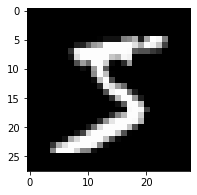

In [4]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')

In [5]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator,self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)

        self.fc4 = nn.Linear(hidden_dim, output_size)

        self.dropout = nn.Dropout(0.3)

    def forward(self,x):

        x = x.view(-1,28*28)

        a1 = F.leaky_relu(self.fc1(x),0.2)
        a1 = self.dropout(a1)

        a2 = F.leaky_relu(self.fc2(a1),0.2)
        a2 = self.dropout(a2)

        a3 = F.leaky_relu(self.fc3(a2),0.2)
        a3 = self.dropout(a3)

        a4 = self.fc4(a3)

        return a4


In [6]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

        self.fc4 = nn.Linear(hidden_dim*4, output_size)

        self.dropout = nn.Dropout(0.3)

    def forward(self,x):

        a1 = F.leaky_relu(self.fc1(x), 0.2)
        a1 = self.dropout(a1)

        a2 = F.leaky_relu(self.fc2(a1), 0.2)
        a2 = self.dropout(a2)

        a3 = F.leaky_relu(self.fc3(a2), 0.2)
        a3 = self.dropout(a3)

        a4 = F.tanh(self.fc4(a3))

        return a4

In [7]:
input_size = 784
d_output_size = 1
d_hidden_size = 32

z_size = 100
g_output_size = 784
g_hidden_size = 32

In [8]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [9]:
def real_loss(D_out,smooth = False):
    
    batch_size = D_out.size(0)

    if smooth:

        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss 

def fake_loss(D_out):

    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(),labels)
    return loss 


In [10]:
d_optimizer = optim.Adam(D.parameters(), lr = 0.001)
g_optimizer = optim.Adam(G.parameters(), lr = 0.001)

In [11]:
epochs = 300

In [12]:
samples = []
losses = []
print_every = 400

sample_size = 16
fixed_z = np.random.uniform(-1,1, size = (sample_size,z_size))
fixed_z = torch.from_numpy(fixed_z).float()

In [13]:
D.train()
G.train()

for epoch in range(epochs):

    for batch_i, (real_images, _) in enumerate(trainloader):
        
        batch_size = real_images.size(0)

        real_images = real_images*2 - 1
        d_optimizer.zero_grad()

        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)


        z = np.random.uniform(-1,1,size = (batch_size,z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()

        d_optimizer.step()

        g_optimizer.zero_grad()

        z = np.random.uniform(-1,1,size = (batch_size,z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)

        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print('Epoch {:5d}/{:5d} | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, epochs, d_loss.item(), g_loss.item()))

    
    losses.append((d_loss.item(),g_loss.item()))

    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()


Epoch     1/  300 | d_loss: 1.3591 | g_loss: 0.7511
Epoch     1/  300 | d_loss: 0.6049 | g_loss: 2.1851
Epoch     1/  300 | d_loss: 0.9805 | g_loss: 1.7896
Epoch     2/  300 | d_loss: 1.7748 | g_loss: 0.3173
Epoch     2/  300 | d_loss: 0.7122 | g_loss: 2.7290
Epoch     2/  300 | d_loss: 0.6658 | g_loss: 3.1013
Epoch     3/  300 | d_loss: 0.6849 | g_loss: 2.1074
Epoch     3/  300 | d_loss: 0.6895 | g_loss: 3.6299
Epoch     3/  300 | d_loss: 1.0958 | g_loss: 1.5619
Epoch     4/  300 | d_loss: 1.5216 | g_loss: 1.6559
Epoch     4/  300 | d_loss: 0.8494 | g_loss: 2.3802
Epoch     4/  300 | d_loss: 1.0495 | g_loss: 1.0005
Epoch     5/  300 | d_loss: 1.3282 | g_loss: 1.1831
Epoch     5/  300 | d_loss: 0.9242 | g_loss: 1.8418
Epoch     5/  300 | d_loss: 0.8225 | g_loss: 2.1880
Epoch     6/  300 | d_loss: 1.1716 | g_loss: 1.2098
Epoch     6/  300 | d_loss: 0.9783 | g_loss: 1.5740
Epoch     6/  300 | d_loss: 1.0895 | g_loss: 1.3936
Epoch     7/  300 | d_loss: 0.9318 | g_loss: 1.9204
Epoch     7/

In [14]:
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

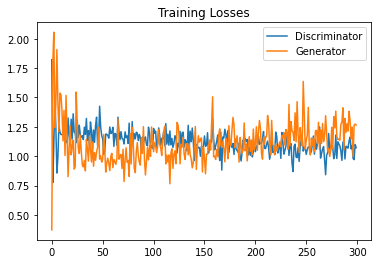

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator') 
plt.title("Training Losses")
plt.legend()

In [16]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [17]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

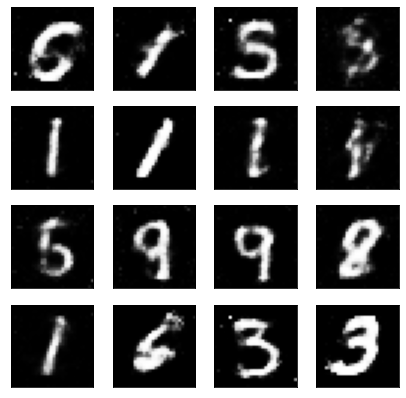

In [23]:
view_samples(299, samples)

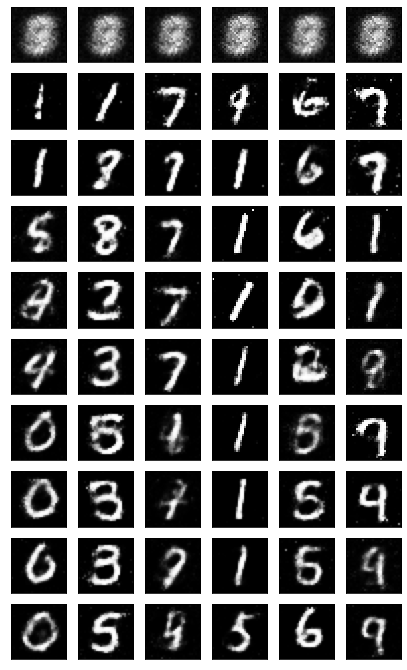

In [19]:
rows = 10
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)